In [ ]:
!pip install xgboost

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

def get_files_path(files_name):
    files_path = []
    for root, dirs, files in os.walk('../data/'):
        for file in files:
            if file.endswith(files_name):
                files_path.append(os.path.join(root, file))
    return sorted(files_path)

def get_Sn_cell_path(files_name, n):
    csv_files = get_files_path(files_name)
    if n == 'all':
        return csv_files
    return [path for path in csv_files if n in path]

FILES = {
    'BMS':'_BMS_influxdb_data.csv',
    'voltage':'_voltage_influxdb_data.csv',
    'temperature':'temperature_influxdb_data.csv'
}

SnCELL =['all', 'S1_cell', 'S2_cell', 'S3_cell', 'S4_cell', 'S5_cell', 'S6_cell']

def load_data(files):
    data = [pd.read_csv(file, index_col=[0]) for file in files]
    df = pd.concat(data, ignore_index=True)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)

    df = df[['timestamp','SOH', 'System voltage', 'System Current', 'SOC']]
     
    df['timestamp'] = df['timestamp'].dt.floor('s')
    df = df[~df['timestamp'].duplicated(keep='first')]
    df = df.set_index('timestamp').resample('1T').first().reset_index()
    df = df.dropna(subset=['System voltage'])
    df = df[df['System voltage'] != 0]
    return df


def create_time_feature(df):
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    return df

In [2]:
bms_files_path = get_files_path(FILES['BMS'])
data = load_data(bms_files_path)
data.head()

/tmp/ipykernel_2149849/474377795.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.set_index('timestamp').resample('1T').first().reset_index()


,timestamp,SOH,System voltage,System Current,SOC
0,2023-06-09 16:00:00+00:00,983.0,13709.0,73.0,617.0
1,2023-06-09 16:01:00+00:00,983.0,13535.0,282.0,615.0
2,2023-06-09 16:02:00+00:00,983.0,13658.0,57.0,615.0
3,2023-06-09 16:03:00+00:00,983.0,13601.0,106.0,613.0
4,2023-06-09 16:04:00+00:00,983.0,13618.0,12.0,612.0


In [3]:
train_data = data.query('timestamp <  "2023-07-22 16:00:00+00:00"').reset_index(drop = True) 
test_data  = data.query('timestamp >= "2023-07-22 16:00:00+00:00"').reset_index(drop = True)

In [4]:
train_data = train_data.set_index('timestamp')
test_data = test_data.set_index('timestamp')

In [5]:
train_data = create_time_feature(train_data)
test_data = create_time_feature(test_data)

In [6]:
test_data.tail()

,SOH,System voltage,System Current,SOC,dayofmonth,dayofweek,quarter,month,year,dayofyear,hour,minute
timestamp,,,,,,,,,,,,
2023-08-31 15:55:00+00:00,973.0,13911.0,-222.0,524.0,31,3,3,8,2023,243,15,55
2023-08-31 15:56:00+00:00,973.0,13816.0,-59.0,525.0,31,3,3,8,2023,243,15,56
2023-08-31 15:57:00+00:00,973.0,13876.0,-185.0,525.0,31,3,3,8,2023,243,15,57
2023-08-31 15:58:00+00:00,973.0,14005.0,-377.0,527.0,31,3,3,8,2023,243,15,58
2023-08-31 15:59:00+00:00,973.0,13805.0,6.0,529.0,31,3,3,8,2023,243,15,59


In [7]:
target = 'SOH'

In [8]:
X_train = train_data.drop(target, axis =1)
y_train = train_data[target]

X_test = test_data.drop(target, axis =1)
y_test = test_data[target]

In [9]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

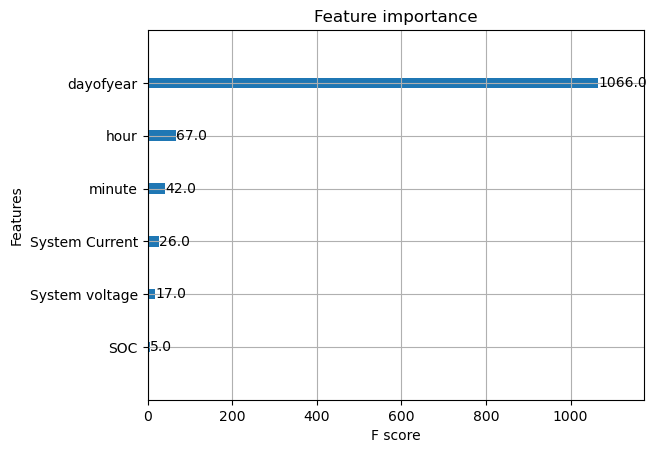

In [10]:
xgb.plot_importance(reg)

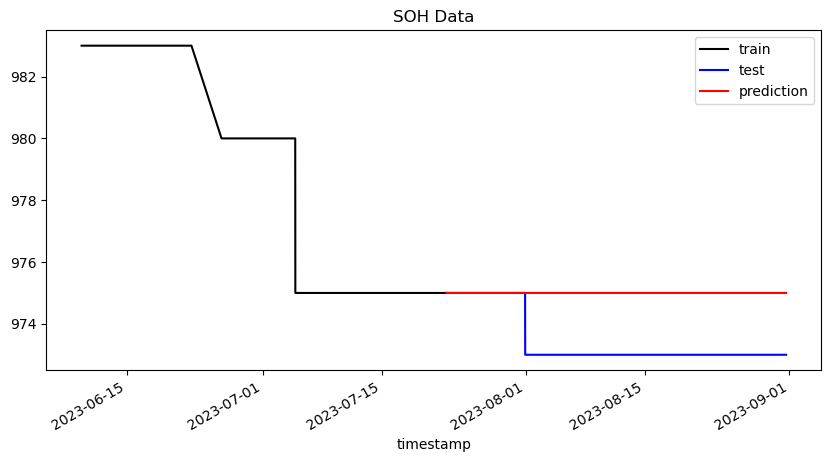

In [11]:
test_data['SOH_Prediction'] = reg.predict(X_test)

train_data[target].plot(style='k', figsize=(10,5), label = 'train')
test_data[target].plot(style='b', figsize=(10,5), label = 'test')
test_data['SOH_Prediction'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('SOH Data')
plt.legend()

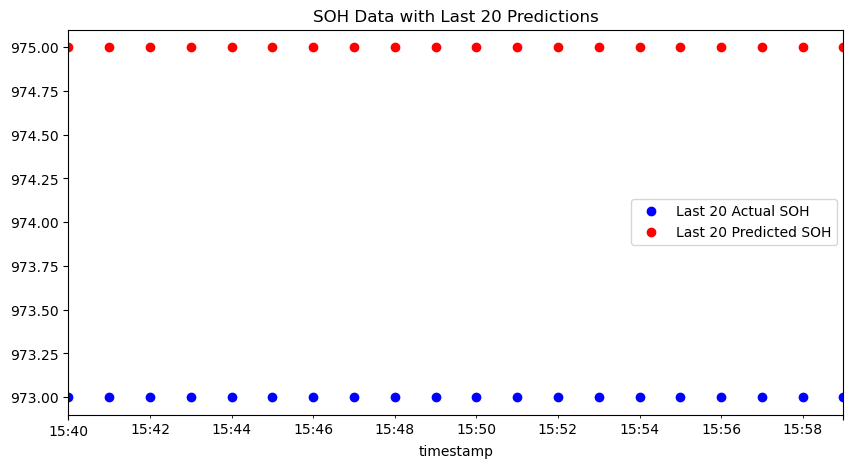

In [12]:
last_20_actual = test_data['SOH'].tail(20)
last_20_pred = test_data['SOH_Prediction'].tail(20)

# 繪製圖形
plt.figure(figsize=(10,5))
last_20_actual.plot(style='bo', label='Last 20 Actual SOH')
last_20_pred.plot(style='ro', label='Last 20 Predicted SOH')

plt.title('SOH Data with Last 20 Predictions')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('RMSE: ', round(mean_squared_error(y_true=test_data[target],y_pred=test_data['SOH_Prediction']),3))
print('MAE: ', round(mean_absolute_error(y_true=test_data[target],y_pred=test_data['SOH_Prediction']),3))
print('MAPE: ', round(mean_absolute_percentage_error(y_true=test_data[target],y_pred=test_data['SOH_Prediction']),3))

RMSE:  3.082
MAE:  1.541
MAPE:  0.002
